<a href="https://colab.research.google.com/github/nimsara66/ML-Project/blob/main/Speech_based_Classification_Layer_9_Label_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import Datasets

In [2]:
train_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/train.csv"
valid_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/valid.csv"
test_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/test.csv"

train_data = pd.read_csv(train_csv_url)
valid_data = pd.read_csv(valid_csv_url)
test_data = pd.read_csv(test_csv_url)

print("Train data:")
print(train_data.head())
print("Valid data:")
print(valid_data.head())
print("Test data:")
print(test_data.head())

Train data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.019301   0.059756   0.081375   0.057481  -0.068440  -0.165913   
1   0.049741   0.090030   0.035118  -0.013676  -0.194317  -0.101763   
2   0.019212   0.087779   0.093907  -0.033738  -0.141409  -0.062881   
3   0.070283   0.049040   0.042126   0.122637  -0.056964  -0.113700   
4   0.028864   0.165634   0.016302   0.036117  -0.028871  -0.147748   

   feature_7  feature_8  feature_9  feature_10  ...  feature_763  feature_764  \
0   0.035643  -0.091138   0.021688    0.057158  ...    -0.035576     0.127319   
1   0.085875  -0.081317   0.112418    0.120523  ...     0.020538     0.058968   
2  -0.071402  -0.006599   0.020372   -0.027777  ...     0.119645    -0.040861   
3   0.108454   0.051336   0.086610    0.141578  ...    -0.124494    -0.169225   
4   0.053180   0.025071  -0.004200   -0.022183  ...    -0.124862     0.044907   

   feature_765  feature_766  feature_767  feature_768  label_1  label_2  \

# Data Visualization

In [5]:
def visualize_label(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

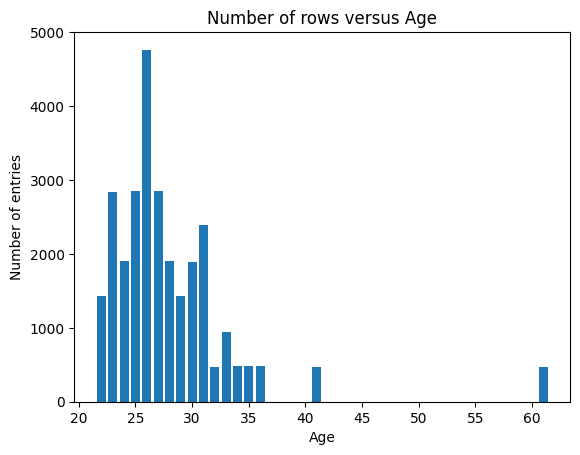

In [7]:
visualize_label(train_data['label_2'], "Number of rows versus Age","Age")

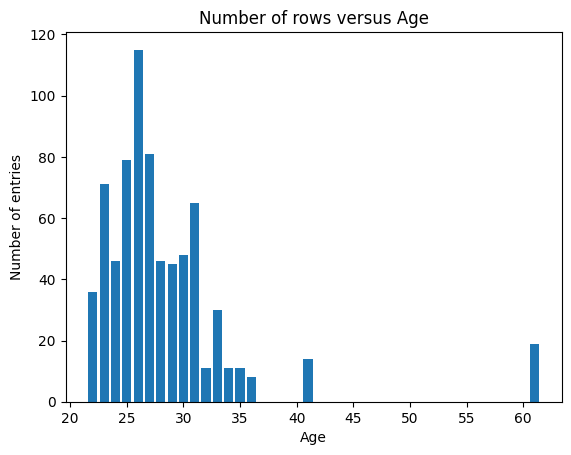

In [8]:
visualize_label(valid_data['label_2'], "Number of rows versus Age","Age")

# Outlier Detection and Removal

In [17]:
from scipy.stats import norm

def visualize_label_norm(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)

  rng = np.arange(train_data["label_2"].min(), train_data["label_2"].max(), 0.1)
  plt.plot(rng, norm.pdf(rng,train_data["label_2"].mean(),train_data["label_2"].std()))
  plt.show()

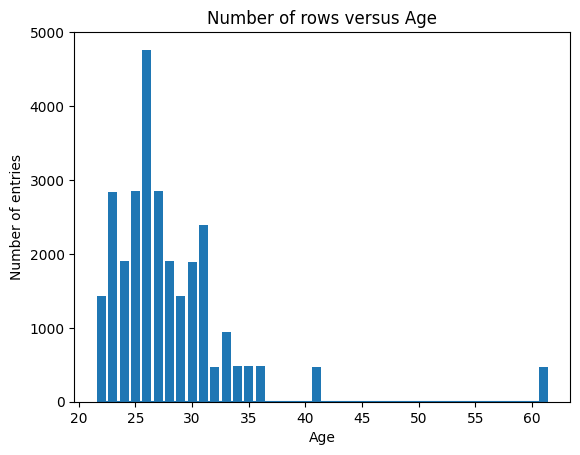

In [18]:
visualize_label_norm(train_data['label_2'], "Number of rows versus Age","Age")

In [19]:
train_data['zscore'] = ( train_data["label_2"] - train_data["label_2"].mean() ) / train_data["label_2"].std()
outliers = train_data[(train_data.zscore<-3) | (train_data.zscore>3)]
outliers.shape

(467, 773)

467 outliers to remove

# Train without Feaure Reduction

In [21]:
print(f"train_data dataset shape {train_data.shape}")
print(f"# of missing values {train_data['label_2'].isna().sum()}")
print(f"# of labels {train_data['label_2'].value_counts().shape[0]}")
print(f"label summary\n{train_data['label_2'].value_counts()}")

train_data dataset shape (28520, 773)
# of missing values 480
# of labels 17
label summary
26.0    4762
25.0    2849
27.0    2846
23.0    2842
31.0    2385
24.0    1906
28.0    1899
30.0    1894
22.0    1432
29.0    1424
33.0     945
36.0     481
35.0     480
34.0     478
32.0     476
41.0     474
61.0     467
Name: label_2, dtype: int64


In [22]:
train_data.dropna(subset=['label_2'], inplace=True)
print(f"train_data dataset shape {train_data.shape}")

train_data dataset shape (28040, 773)


Feature Enginering

*   Label_2 has missing values and they were dropped
*   Label_2 has 17 unique classes
*   Using one-hot encoding for multilabel classification



In [23]:
label_2 = train_data['label_2'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_2)
print(ohe.categories_)

label_2 = ohe.transform(label_2)
print(label_2)

[array([22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 41., 61.])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :768], label_2, test_size=0.2, stratify=label_2, random_state=2023)

In [25]:
X_train_tensors = torch.tensor(X_train.iloc[:, :].values, dtype=torch.float32)
print(X_train_tensors.shape)

X_test_tensors = torch.tensor(X_test.iloc[:, :].values, dtype=torch.float32)
print(X_test_tensors.shape)

torch.Size([22432, 768])
torch.Size([5608, 768])


## Define the Model

In [26]:
class AgeClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(AgeClassifier, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 17)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

## Train the model

In [27]:
# Create an instance of the AgeClassifier model
ageClassifier = AgeClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors, torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(ageClassifier.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = ageClassifier(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = ageClassifier.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        ageClassifier.eval()
        y_test_pred = ageClassifier(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        ageClassifier.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(ageClassifier.state_dict(), 'ageClassifier_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.7730616042775749, Accuracy=0.4069186747074127
Epoch 1 validation: Cross-entropy=1.1643320825881498, Accuracy=0.609308123588562
Epoch 2 validation: Cross-entropy=0.858403626241993, Accuracy=0.7164764404296875
Epoch 3 validation: Cross-entropy=0.6236764127232739, Accuracy=0.7935092449188232
Epoch 4 validation: Cross-entropy=0.5266084973387939, Accuracy=0.8286376595497131
Epoch 5 validation: Cross-entropy=0.48551147714345294, Accuracy=0.8380884528160095
Epoch 6 validation: Cross-entropy=0.40394442566345135, Accuracy=0.871433675289154
Epoch 7 validation: Cross-entropy=0.36573149471230665, Accuracy=0.882667601108551
Epoch 8 validation: Cross-entropy=0.36588679286886194, Accuracy=0.8860556483268738
Epoch 9 validation: Cross-entropy=0.31716000469595923, Accuracy=0.9003209471702576
Epoch 10 validation: Cross-entropy=0.32367166148397014, Accuracy=0.9013908505439758
Epoch 11 validation: Cross-entropy=0.33086390524240056, Accuracy=0.898537814617157
Epoch 12 val

In [54]:
# Create an instance of the model
ageClassifier = AgeClassifier()

# Load the saved model state dictionary
ageClassifier.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/ageClassifier_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    ageClassifier.eval()
    y_test_pred = ageClassifier(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

Best model validation: Cross-entropy=0.33261258232673724, Accuracy=0.9438302516937256


## Evaluation of the Model

In [23]:
valid_data.dropna(subset=['label_2'], inplace=True)
print(f"valid_data dataset shape {valid_data.shape}")

valid_data dataset shape (736, 772)


In [24]:
label_2_eval = valid_data['label_2'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_2_eval)
print(ohe.categories_)

label_2_eval = ohe.transform(label_2_eval)
print(label_2_eval)

[array([22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 41., 61.])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
# Set your model to evaluation mode
ageClassifier.eval()

X_valid_tensors = torch.tensor(valid_data.iloc[:, :768].values, dtype=torch.float32)
print(X_valid_tensors.shape)

y_pred = ageClassifier(X_valid_tensors)
ce = criterion(y_pred, torch.tensor(label_2_eval))
acc = (torch.argmax(y_pred, 1) == torch.argmax(torch.tensor(label_2_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([736, 768])
Cross-entropy=0.356702677680085, Test Accuracy=0.9429348111152649


In [35]:
y_pred_labels = torch.argmax(y_pred, axis=1).numpy()
label_2_np = torch.argmax(torch.tensor(label_2_eval), axis=1).numpy()

confusion = confusion_matrix(label_2_np, y_pred_labels)
print(classification_report(label_2_np, y_pred_labels))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       0.92      0.94      0.93        71
           2       0.90      1.00      0.95        46
           3       0.94      0.92      0.93        79
           4       0.95      0.93      0.94       115
           5       0.97      0.94      0.96        81
           6       0.95      0.89      0.92        46
           7       0.96      1.00      0.98        45
           8       0.90      0.96      0.93        48
           9       0.98      0.94      0.96        65
          10       0.92      1.00      0.96        11
          11       0.94      0.97      0.95        30
          12       0.92      1.00      0.96        11
          13       1.00      0.91      0.95        11
          14       0.89      1.00      0.94         8
          15       1.00      0.71      0.83        14
          16       0.94      0.89      0.92        19

    accuracy              

In [36]:
accuracy_score(label_2_np, y_pred_labels)

0.9429347826086957

## Get Test Results

In [4]:
test_data.dropna(subset=['label_2'], inplace=True)
print(f"test_data dataset shape {test_data.shape}")

In [62]:
label_2_t = test_data['label_2'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_2_t)
print(ohe.categories_)

label_2_t = ohe.transform(label_2_t)
print(label_2_t)

[array([22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 41., 61.])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [63]:
# Set your model to evaluation mode
ageClassifier.eval()

X_t_tensors = torch.tensor(test_data.iloc[:, :768].values, dtype=torch.float32)
print(X_t_tensors.shape)

y_pred_t = ageClassifier(X_t_tensors)
ce = criterion(y_pred_t, torch.tensor(label_2_t))
acc = (torch.argmax(y_pred_t, 1) == torch.argmax(torch.tensor(label_2_t), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([28040, 768])
Cross-entropy=0.06883548555468619, Test Accuracy=0.9880527853965759


In [64]:
y_pred_t_labels = torch.argmax(y_pred_t, axis=1).numpy()
label_2_np_t = torch.argmax(torch.tensor(label_2_t), axis=1).numpy()

confusion = confusion_matrix(label_2_np_t, y_pred_t_labels)
print(classification_report(label_2_np_t, y_pred_t_labels))

accuracy_score(label_2_np_t, y_pred_t_labels)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1432
           1       0.99      0.98      0.98      2842
           2       0.98      0.99      0.98      1906
           3       0.98      0.99      0.99      2849
           4       0.99      0.99      0.99      4762
           5       0.99      0.99      0.99      2846
           6       0.99      0.98      0.99      1899
           7       0.99      0.99      0.99      1424
           8       0.99      0.98      0.99      1894
           9       0.99      0.99      0.99      2385
          10       0.98      1.00      0.99       476
          11       0.99      1.00      0.99       945
          12       0.99      0.99      0.99       478
          13       1.00      1.00      1.00       480
          14       1.00      0.99      0.99       481
          15       0.99      0.99      0.99       474
          16       1.00      0.99      0.99       467

    accuracy              

0.9880527817403709

# Train with Feature Engineering

In [28]:
data_features = train_data.iloc[:, :768]

## Drop Constant Features Using Variance Threshold

In [6]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(data_features)

VarianceThreshold(threshold=0)

In [39]:
constant_columns = [column for column in data_features.columns
                    if column not in data_features.columns[var_thres.get_support()]]

print(constant_columns)

[]


There is no constant columns

## Drop Features Using Pearson Correlation

In [7]:
data_features.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
feature_1,1.000000,0.065348,-0.039416,0.116528,0.108225,-0.163679,0.131004,-0.073198,-0.045476,-0.120560,...,-0.225724,0.290177,0.015310,0.144664,-0.110313,-0.040330,0.132620,0.032706,0.035296,-0.039317
feature_2,0.065348,1.000000,0.043611,0.068624,-0.278709,0.052155,-0.267946,-0.214403,-0.235840,-0.056829,...,-0.150852,-0.096604,0.287950,-0.099087,0.269144,0.005612,-0.068710,-0.204834,-0.350866,0.162593
feature_3,-0.039416,0.043611,1.000000,-0.185437,-0.313107,-0.103496,-0.214606,-0.185952,0.155197,0.011407,...,-0.248988,-0.162378,-0.024814,0.162806,0.231606,0.204807,0.133835,-0.063354,0.159975,0.217143
feature_4,0.116528,0.068624,-0.185437,1.000000,0.096349,-0.220416,0.194002,0.027816,-0.144393,-0.148927,...,0.135598,0.071113,-0.084978,-0.166751,-0.220446,0.103712,0.100221,0.006758,0.034292,-0.128138
feature_5,0.108225,-0.278709,-0.313107,0.096349,1.000000,0.021056,0.325761,-0.000900,0.038333,-0.116997,...,-0.020572,0.024932,-0.202849,0.031865,-0.371326,-0.087327,-0.063512,0.016875,-0.031415,-0.203071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_764,-0.040330,0.005612,0.204807,0.103712,-0.087327,-0.174192,0.122454,0.012446,0.199985,0.171440,...,0.075743,0.065512,-0.313912,-0.196618,-0.114188,1.000000,0.208730,0.181622,0.405485,-0.009266
feature_765,0.132620,-0.068710,0.133835,0.100221,-0.063512,-0.345465,-0.002038,0.005804,0.053829,-0.116723,...,-0.103060,0.180543,-0.010908,-0.076788,0.228983,0.208730,1.000000,-0.204636,0.278358,-0.172730
feature_766,0.032706,-0.204834,-0.063354,0.006758,0.016875,-0.233690,0.282928,-0.105139,0.097498,0.391228,...,0.096985,0.293527,-0.266795,0.168379,-0.486373,0.181622,-0.204636,1.000000,0.388446,-0.065182
feature_767,0.035296,-0.350866,0.159975,0.034292,-0.031415,-0.350340,0.185927,0.045446,0.113304,0.265687,...,0.115303,0.274362,-0.343106,0.081103,-0.327079,0.405485,0.278358,0.388446,1.000000,-0.132940


In [ ]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [8]:
def correlation(dataset, threshold):
    correlated_pairs = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.index[j]  # getting the name of row
                correlated_pairs.add((rowname, colname))
    return correlated_pairs

def get_less_correlated_features(correlated_pairs, dataset, target_column):
    less_correlated_features = {}

    for (feature1, feature2) in correlated_pairs:
        corr1 = dataset[feature1].corr(dataset[target_column])
        corr2 = dataset[feature2].corr(dataset[target_column])

        if abs(corr1) < abs(corr2):
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature1
        else:
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature2

    return less_correlated_features

In [9]:
corr_feature_pairs = correlation(data_features, 0.9)
corr_feature_pairs

{('feature_210', 'feature_609')}

In [10]:
less_correlated_features = get_less_correlated_features(corr_feature_pairs, train_data, "label_2")
less_correlated_features

{frozenset({'feature_210', 'feature_609'}): 'feature_210'}

In [11]:
corr_features = set(less_correlated_features.values())
corr_features

{'feature_210'}

In [29]:
new_features = data_features.drop(corr_features,axis=1)

In [30]:
print(data_features.shape)
print(new_features.shape)

(28040, 768)
(28040, 767)


## Train the model

In [14]:
class AgeClassifierAfter(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(AgeClassifierAfter, self).__init__()
        self.linear1 = nn.Linear(767, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 17)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

In [31]:
label_2 = train_data['label_2'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_2)
print(ohe.categories_)

label_2 = ohe.transform(label_2)
print(label_2)

[array([22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 41., 61.])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(new_features, label_2, test_size=0.2, stratify=label_2, random_state=2023)

X_train_tensors_after = torch.tensor(X_train_after.values, dtype=torch.float32)
print(X_train_tensors_after.shape)


X_test_tensors_after = torch.tensor(X_test_after.values, dtype=torch.float32)
print(X_test_tensors_after.shape)

torch.Size([22432, 767])
torch.Size([5608, 767])


In [33]:
y_train_after.shape

(22432, 17)

In [53]:
# Create an instance of the AgeClassifierAfter model
ageClassifierAfter = AgeClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors_after, torch.tensor(y_train_after))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(ageClassifierAfter.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = ageClassifierAfter(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = ageClassifierAfter.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        ageClassifierAfter.eval()
        y_test_pred_after = ageClassifierAfter(X_test_tensors_after)
        ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
        acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()
        ageClassifierAfter.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(ageClassifierAfter.state_dict(), 'ageClassifierAfter_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.7582267233118756, Accuracy=0.4115549325942993
Epoch 1 validation: Cross-entropy=1.1788258352076113, Accuracy=0.605028510093689
Epoch 2 validation: Cross-entropy=0.9294041022047469, Accuracy=0.6924037337303162
Epoch 3 validation: Cross-entropy=0.6491924954814635, Accuracy=0.7870898842811584
Epoch 4 validation: Cross-entropy=0.5363727365550456, Accuracy=0.8223965764045715
Epoch 5 validation: Cross-entropy=0.46117015990548205, Accuracy=0.848074197769165
Epoch 6 validation: Cross-entropy=0.4400310909588797, Accuracy=0.8544935584068298
Epoch 7 validation: Cross-entropy=0.3848966928383065, Accuracy=0.8807061314582825
Epoch 8 validation: Cross-entropy=0.38282533642589894, Accuracy=0.879279613494873
Epoch 9 validation: Cross-entropy=0.33150331891007745, Accuracy=0.898181140422821
Epoch 10 validation: Cross-entropy=0.34744213977425437, Accuracy=0.8915834426879883
Epoch 11 validation: Cross-entropy=0.3398351220489623, Accuracy=0.8988944292068481
Epoch 12 valid

In [34]:
# Create an instance of the model
ageClassifierAfter = AgeClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Load the saved model state dictionary
ageClassifierAfter.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/ageClassifierAfter_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    ageClassifierAfter.eval()
    y_test_pred_after = ageClassifierAfter(X_test_tensors_after)
    ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
    acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")


Best model validation: Cross-entropy=0.33409853469560713, Accuracy=0.9427603483200073


## Evaluation of the Model

In [37]:
# Set your model to evaluation mode
ageClassifierAfter.eval()

new_features_valid = valid_data.iloc[:, :768].drop(corr_features,axis=1)
X_valid_tensors_after = torch.tensor(new_features_valid.values, dtype=torch.float32)
print(X_valid_tensors_after.shape)

y_pred_valid_after = ageClassifierAfter(X_valid_tensors_after)
ce = criterion(y_pred_valid_after, torch.tensor(label_2_eval))
acc = (torch.argmax(y_pred_valid_after, 1) == torch.argmax(torch.tensor(label_2_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([736, 767])
Cross-entropy=0.29291160724206255, Test Accuracy=0.945652186870575


In [38]:
y_pred_valid_after_labels = torch.argmax(y_pred_valid_after, axis=1).numpy()
label_2_np_valid_after = torch.argmax(torch.tensor(label_2_eval), axis=1).numpy()

confusion = confusion_matrix(label_2_np_valid_after, y_pred_valid_after_labels)
print(classification_report(label_2_np_valid_after, y_pred_valid_after_labels))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.94      0.93      0.94        71
           2       0.90      1.00      0.95        46
           3       0.97      0.92      0.95        79
           4       0.92      0.95      0.94       115
           5       0.99      0.96      0.97        81
           6       0.89      0.91      0.90        46
           7       0.96      0.96      0.96        45
           8       0.94      0.96      0.95        48
           9       0.95      0.95      0.95        65
          10       1.00      1.00      1.00        11
          11       0.97      1.00      0.98        30
          12       1.00      1.00      1.00        11
          13       1.00      0.91      0.95        11
          14       0.80      1.00      0.89         8
          15       0.91      0.71      0.80        14
          16       1.00      0.89      0.94        19

    accuracy              

In [39]:
accuracy_score(label_2_np_valid_after, y_pred_valid_after_labels)

0.9456521739130435

## Get Test Results

In [41]:
# Set your model to evaluation mode
ageClassifierAfter.eval()

new_features_test = test_data.iloc[:, :768].drop(corr_features,axis=1)
X_t_tensors_after = torch.tensor(new_features_test.values, dtype=torch.float32)
print(X_t_tensors_after.shape)

y_pred_t_after = ageClassifierAfter(X_t_tensors_after)
print(y_pred_t_after.shape)

torch.Size([744, 767])
torch.Size([744, 17])


In [42]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t_after.detach().numpy())
test_data["label_2"] = pd.DataFrame(y_pred_one_hot, columns=["label_2"])

In [43]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_2
0,1,0.013112,0.130904,0.020284,0.063018,-0.034321,-0.073516,-0.030659,-0.064994,0.024153,...,0.241121,0.079949,-0.186099,-0.096718,0.126006,-0.023069,0.190374,0.146516,0.038047,30.0
1,2,0.005934,0.138592,-0.007000,0.055925,-0.021927,-0.084788,0.013339,0.060811,-0.011344,...,0.042921,0.018571,-0.114785,-0.105186,0.059050,0.021443,0.013027,0.046826,-0.026682,30.0
2,3,-0.067210,0.078710,-0.044344,0.101248,-0.074331,-0.088951,0.074616,0.007231,0.021091,...,0.053370,0.096232,-0.369018,-0.066708,-0.003730,-0.063339,-0.044497,-0.024363,-0.042594,30.0
3,4,-0.005678,0.060703,0.033954,0.068771,-0.039923,-0.186583,0.014921,0.020791,0.017441,...,0.018405,-0.018047,-0.080393,-0.114030,0.048255,0.033839,0.035026,-0.047988,-0.038252,31.0
4,5,-0.076360,0.061095,-0.004938,0.066692,-0.040454,-0.005141,-0.003213,0.025721,0.083558,...,0.045479,0.057146,-0.194466,0.000739,0.018702,0.013192,-0.038486,0.033358,-0.038452,30.0


In [46]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/label_2.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)